# Training a Unet model for segmentation

Importing useful packages

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor

import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import ipdb
import pandas as pd

Useful paths

In [2]:
TILE_PATH = './dataset/tiles/images/'
TILE_GT_PATH = './dataset/tiles/ground_truth/'
LABELS_FILE = './dataset/tiles/labels.csv'

### Loading the data

First we create a Dataset object and a transform function that converts a data point to a tensor. We load the tile dataset and then we split it randomly as follows: 

* 10% N1 train - pixel-level labels;
* 70% N2 train - class labels;
* 20% validation - validation set.

In [3]:
class VaihingenDataset(Dataset):

    def __init__(self, img_dir, gt_dir, labels_f, strong_idx, weak_idx=[], transform=None):

        self.img_dir = img_dir
        self.gt_dir = gt_dir
        self.labels_f = labels_f
        
        self.strong_idx = strong_idx
        self.weak_idx = weak_idx
        
        self.labels = pd.read_csv(labels_f, header=None)

        self.transform = transform

    def __len__(self):
        return len(self.strong_idx) + len(self.weak_idx)

    def __getitem__(self, idx):
        
        f_name = self.labels.iloc[idx][0]

        img_name = os.path.join(self.img_dir, '{}.png'.format(f_name))
        gt_name = os.path.join(self.gt_dir, '{}.png'.format(f_name))
            
        labels = np.array(self.labels.iloc[idx][1:])
        
        img = io.imread(img_name) 
        gt = io.imread(gt_name)
        
        # normalizing the data
        img_float = img / 255.
        gt_float = gt / 255.
        
        if idx in self.weak_idx:
            sample = {
                'image': img_float.astype(np.float32),
                'ground_truth': gt_float.astype(np.float32),
                'labels': labels.astype(np.float32),
                'strong': False
            }
        else:
            sample = {
                'image': img_float.astype(np.float32),
                'ground_truth': gt_float.astype(np.float32),
                'labels': labels.astype(np.float32),
                'strong': True
            }
                
        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
class ToTensor(object):

    def __call__(self, sample):
        img, gt, labels, strong = sample['image'], sample['ground_truth'], sample['labels'], sample['strong']

        # swapping axes for images
        img = img.transpose((2, 0, 1))
        gt = gt.transpose((2, 0, 1))
        
        return {
            'image': torch.from_numpy(img),
            'ground_truth': torch.from_numpy(gt),
            'labels': torch.from_numpy(labels),
            'strong': strong
        }

In [5]:
file_list = pd.read_csv(LABELS_FILE)

strong_ds_len = int(0.1 * len(file_list))
weak_ds_len = int(0.7 * len(file_list))
valid_ds_len = len(file_list) - strong_ds_len - weak_ds_len

# we split the data in a deterministic way to consistently measure the results
strong_idx = np.asarray(range(0, strong_ds_len))
weak_idx = np.asarray(range(strong_ds_len, strong_ds_len + weak_ds_len))
valid_idx = np.asarray(range(strong_ds_len + weak_ds_len, len(file_list)))

print('Strong labels set size: {}/{}.'.format(strong_ds_len, len(file_list)))
print('Weak labels set size: {}/{}.'.format(weak_ds_len, len(file_list)))
print('Validation set size: {}/{}.'.format(valid_ds_len, len(file_list)))

Strong labels set size: 1463/14635.
Weak labels set size: 10244/14635.
Validation set size: 2928/14635.


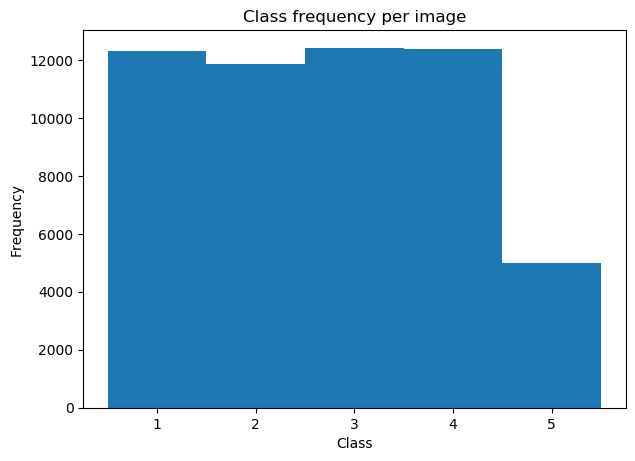

In [6]:
class_freq_per_img = np.array(file_list.iloc[:, 1:]).sum(axis=0)

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

plt.bar(list(range(1,6)), class_freq_per_img, 1)

plt.title('Class frequency per image')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [7]:
from utils import color_key

color_key = np.asarray(color_key) / 255.
class_freq_per_pixel = np.zeros(5)

simple_ds = VaihingenDataset(TILE_PATH, TILE_GT_PATH, LABELS_FILE, strong_idx, weak_idx)

for i in strong_idx:
    data_point = simple_ds[i]['ground_truth']
    for j in range(len(color_key)):
        class_freq_per_pixel[j] += np.count_nonzero((data_point == color_key[j]).all(2))

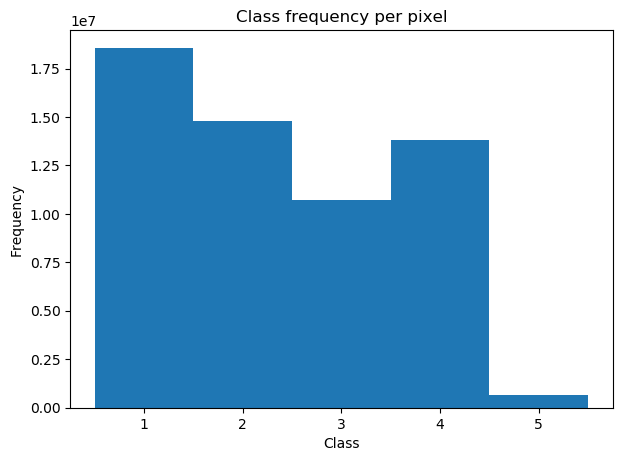

In [8]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

plt.bar(list(range(1,6)), class_freq_per_pixel, 1)

plt.title('Class frequency per pixel')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [6]:
ds_train_strong = VaihingenDataset(TILE_PATH, TILE_GT_PATH, LABELS_FILE, strong_idx, transform=ToTensor())
ds_train_full = VaihingenDataset(TILE_PATH, TILE_GT_PATH, LABELS_FILE, strong_idx, weak_idx, transform=ToTensor())
ds_valid = VaihingenDataset(TILE_PATH, TILE_GT_PATH, LABELS_FILE, valid_idx, transform=ToTensor())

We define a data loader for each subset

In [7]:
BATCH_SIZE = 16

strong_dataloader = DataLoader(ds_train_strong, batch_size=BATCH_SIZE)
full_dataloader = DataLoader(ds_train_full, batch_size=BATCH_SIZE)
valid_dataloader = DataLoader(ds_valid, batch_size=BATCH_SIZE)

### Training & testing the segmentation model

We are using a Unet model; the architecture is part of the tutorial that can be found [here](https://www.youtube.com/watch?v=IHq1t7NxS8k).

In [8]:
from UNET import UNET

model = UNET(out_channels=3)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
print(model)

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

if torch.cuda.is_available():
    model.cuda()

Using cuda device


In [14]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, data in enumerate(dataloader):
        img, gt, labels = data['image'].to(device), data['ground_truth'].to(device), data['labels'].to(device)
        pred = model(img)
        loss = loss_fn(pred, gt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 20 == 0:
            loss, current = loss.item(), batch * len(img)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [15]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for data in dataloader:
            img, gt, labels = data['image'].to(device), data['ground_truth'].to(device), data['labels'].to(device)
            pred = model(img)
            test_loss += loss_fn(pred, gt).item()
            correct += (torch.count_nonzero((pred > 0.5).type(torch.float) - gt)).item()
    test_loss /= num_batches
    correct /= size*200*200
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [16]:
EPOCHS = 3

torch.cuda.empty_cache()

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train(strong_dataloader, model, loss_fn, optimizer)
    test(valid_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.149731  [    0/ 1463]
loss: 0.118119  [  320/ 1463]
loss: 0.110968  [  640/ 1463]
loss: 0.113975  [  960/ 1463]
loss: 0.074201  [ 1280/ 1463]
Test Error: 
 Accuracy: 42.9%, Avg loss: 0.104773 

Epoch 2
-------------------------------
loss: 0.111130  [    0/ 1463]
loss: 0.154504  [  320/ 1463]
loss: 0.091228  [  640/ 1463]
loss: 0.086122  [  960/ 1463]
loss: 0.065659  [ 1280/ 1463]
Test Error: 
 Accuracy: 38.1%, Avg loss: 0.091909 

Epoch 3
-------------------------------
loss: 0.094645  [    0/ 1463]
loss: 0.146475  [  320/ 1463]
loss: 0.090708  [  640/ 1463]
loss: 0.080001  [  960/ 1463]
loss: 0.072882  [ 1280/ 1463]
Test Error: 
 Accuracy: 36.4%, Avg loss: 0.089819 

Done!


Saving the model

In [17]:
MODEL_ID = 'strong_segmentation_model.pth'
SAVED_MODELS_PATH = './saved_models/'

os.makedirs(SAVED_MODELS_PATH, exist_ok=True)

torch.save(model.state_dict(), os.path.join(SAVED_MODELS_PATH, MODEL_ID))

Some example segmentations with the trained model

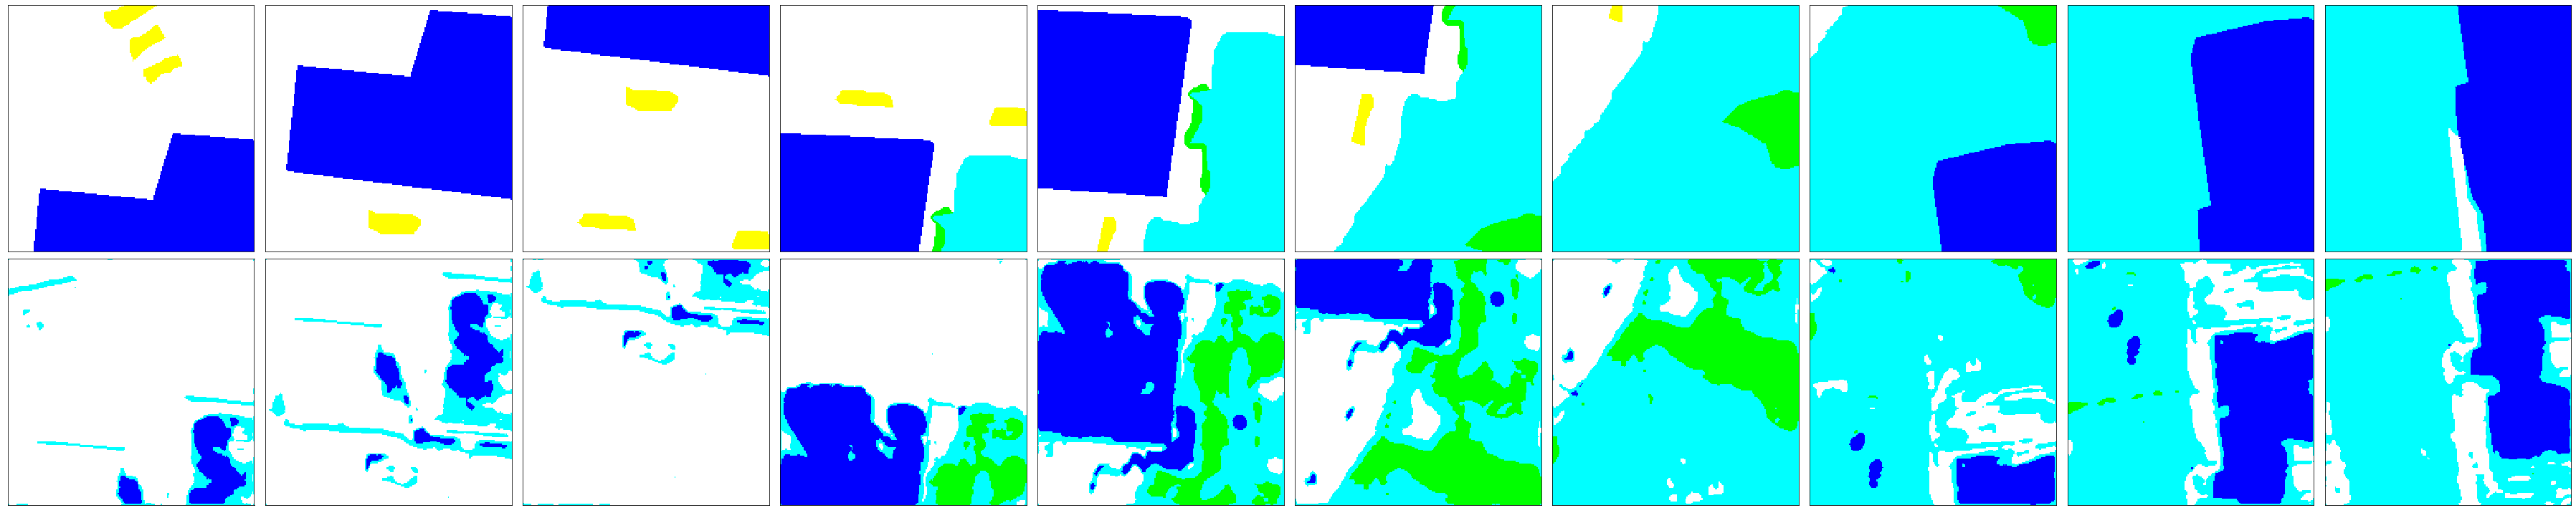

In [20]:
fig=plt.figure(figsize=(60,10))
columns = 12
rows = 2

num_examples = 10

i = 1
for idx in range(num_examples):
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(torch.transpose(ds_valid[idx]['ground_truth'], 0, 2))
    fig.add_subplot(rows, columns, columns + i)
    
    model.eval()
    with torch.no_grad():
        pred = model(torch.unsqueeze(ds_valid[idx]['image'], dim=0).cuda())
        pred = (pred > 0.5).float()
    
    plt.xticks([])
    plt.yticks([])
    plt.imshow(torch.transpose(torch.squeeze(pred.cpu()), 0, 2), cmap='gray')
    i += 1
        
plt.xticks([])
plt.yticks([])
plt.tight_layout()